### Part b): Writing your own Neural Network code

Your aim now, and this is the central part of this project, is to
write your own FFNN code implementing the back
propagation algorithm discussed in the lecture slides from week 41 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week41.html> and week 42 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html>.

We will focus on a regression problem first, using the one-dimensional Runge function

$$
f(x) = \frac{1}{1+25x^2},
$$

from project 1.

Use only the mean-squared error as cost function (no regularization terms) and 
write an FFNN code for a regression problem with a flexible number of hidden
layers and nodes using only the Sigmoid function as activation function for
the hidden layers. Initialize the weights using a normal
distribution. How would you initialize the biases? And which
activation function would you select for the final output layer?
And how would you set up your design/feature matrix? Hint: does it have to represent a polynomial approximation as you did in project 1? 

Train your network and compare the results with those from your OLS
regression code from project 1 using the one-dimensional Runge
function.  When comparing your neural network code with the OLS
results from project 1, use the same data sets which gave you the best
MSE score. Moreover, use the polynomial order from project 1 that gave you the
best result.  Compare these results with your neural network with one
and two hidden layers using $50$ and $100$ hidden nodes, respectively.

Comment your results and give a critical discussion of the results
obtained with the OLS code from project 1 and your own neural network
code.  Make an analysis of the learning rates employed to find the
optimal MSE score. Test both stochastic gradient descent
with RMSprop and ADAM and plain gradient descent with different
learning rates.

You should, as you did in project 1, scale your data.

## Imports

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, prepare_data, neural_network
importlib.reload(prepare_data)
importlib.reload(neural_network)

# --- Our own code ---
from neural_network import NeuralNetwork
from optimizers import SGD, RMSprop, Adam
from losses import mse, mse_deriv
from activations import sigmoid, sigmoid_deriv, linear, linear_deriv, relu, relu_deriv
from prepare_data import prepare_data

## Prepare data

In [42]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

## Building the Neural Network

In [43]:
layer_output_sizes = [20, 10,1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv

nn = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)


## Training the network

In [44]:
lr = 1e-2
optimizer = Adam(lr=lr)
history = nn.fit(x_train, 
                 y_train,
                 epochs=500,
                 batch_size=32,
                 optimizer=optimizer,
                 log_every=100)

Epoch   1 | train: 0.090674
Epoch 100 | train: 0.026268
Epoch 200 | train: 0.000550
Epoch 300 | train: 0.000257
Epoch 400 | train: 0.000122
Epoch 500 | train: 0.000055


## Plotting the fit

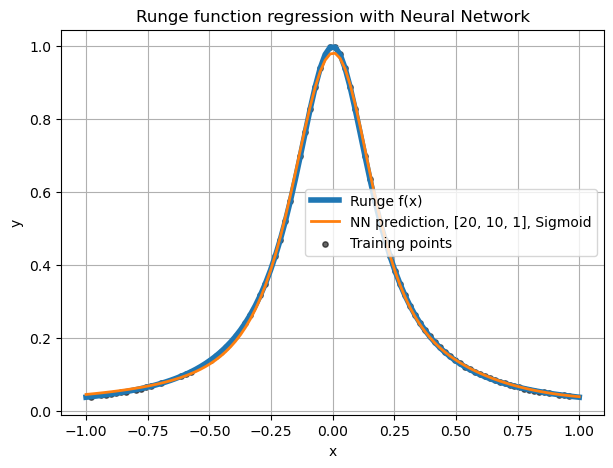

In [45]:
x_plot = x
y_true = y  
x_plot_scaled = scaler_x.transform(x_plot)
y_pred = nn.predict(x_plot_scaled)

x_train_unscaled = scaler_x.inverse_transform(x_train)

# --- 2) Plot sammenligning ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot, y_true, label="Runge f(x)", linewidth=4)
plt.plot(x_plot, y_pred, label=f"NN prediction, {layer_output_sizes}, Sigmoid", linewidth=2)
plt.scatter(x_train_unscaled, y_train, color="black", s=15, alpha=0.6, label="Training points")
plt.title("Runge function regression with Neural Network")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Comparing FFNN with OLS

## Importing implementations from Project 1

In [46]:
from Code_Project1.OLS import OLS_parameters
from Code_Project1.polynomial_features import polynomial_features



## Prepare data

In [47]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data: Neural network, in OLS we scale the feature matrix
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network


## OLS regression

In [48]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)
#Optimal polynomial degree, OLS (from project 1) is p=8
p = 8

# Feature matrix for plotting/predicting
X_plot = polynomial_features(x.ravel(), p, intercept=False)
# Feature matrix for training
X_train = polynomial_features(x_train.ravel(), p, intercept=False)
# Feature matrix for testing
X_test  = polynomial_features(x_test.ravel(), p, intercept=False)

# Scaling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)
X_plot_s  = scaler.transform(X_plot)

# Compute closed-form OLS parameters
beta = OLS_parameters(X_train_s, y_train)

# Compute y_offset (because Intercept = False)
y_offset = np.mean(y_train)
# Add offset to prediction, predict on test data
y_pred_test = X_test_s @ beta + y_offset
y_pred_train = X_train_s @ beta + y_offset
y_pred_full_OLS = X_plot_s @ beta + y_offset
# plt.plot(x, y)
# plt.plot(x, X_plot_s @ beta + y_offset, label=f"Degree: {p}")
# plt.show()

mse_OLS = mse(y_test, y_pred_test)
print(f"MSE test, OLS: {mse_OLS}")

MSE test, OLS: 0.010640517469230401


## FFNN, 1 hidden layer, 50 hidden nodes

In [49]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data: Neural network, in OLS we scale the feature matrix
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network
x_full_s = scaler_x.transform(x)


layer_output_sizes = [50,1]
activation_funcs = [sigmoid, linear]
activation_ders = [sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv

### Construct neural network
nn_1 = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)

# Training (using ADAM optimizer)
lr = 1e-2
optimizer = Adam(lr=lr)
history = nn_1.fit(x_train_s, 
                 y_train,
                 epochs=1000,
                 batch_size=32,
                 optimizer=optimizer,
                 log_every=100)

### Predicting ###
y_pred_nn1 = nn_1.predict(x_full_s)
y_pred_test_nn1 = nn_1.predict(x_test_s)

x_train_unscaled_nn1 = scaler_x.inverse_transform(x_train)

mse_nn1 = mse(y_pred_test_nn1, y_test)
print("MSE: ", mse_nn1)

Epoch   1 | train: 0.117480
Epoch 100 | train: 0.077996
Epoch 200 | train: 0.009644
Epoch 300 | train: 0.002556
Epoch 400 | train: 0.000554
Epoch 500 | train: 0.000339
Epoch 600 | train: 0.000565
Epoch 700 | train: 0.000154
Epoch 800 | train: 0.000114
Epoch 900 | train: 0.000246
Epoch 1000 | train: 0.000044
MSE:  5.285487452439965e-05


## FFNN, 2 hidden layers, 50 hidden nodes per layer

In [55]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data: Neural network, in OLS we scale the feature matrix
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network
x_full_s = scaler_x.transform(x)


layer_output_sizes = [50, 50, 1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv

### Construct neural network
nn_2 = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)

# Training (using ADAM optimizer)
lr = 5e-2
optimizer = Adam(lr=lr)
history = nn_2.fit(x_train_s, 
                 y_train,
                 epochs=500,
                 batch_size=32,
                 optimizer=optimizer,
                 log_every=100)

### Predicting ###
y_pred_nn2 = nn_2.predict(x_full_s)
y_pred_test_nn2 = nn_2.predict(x_test_s)

x_train_unscaled_nn2 = scaler_x.inverse_transform(x_train)

mse_nn2 = mse(y_pred_test_nn2, y_test)
print("MSE: ", mse_nn2)

Epoch   1 | train: 0.149159
Epoch 100 | train: 0.083489
Epoch 200 | train: 0.064723
Epoch 300 | train: 0.062389
Epoch 400 | train: 0.000354
Epoch 500 | train: 0.000036
MSE:  3.582236545652412e-05


### Plotting the results

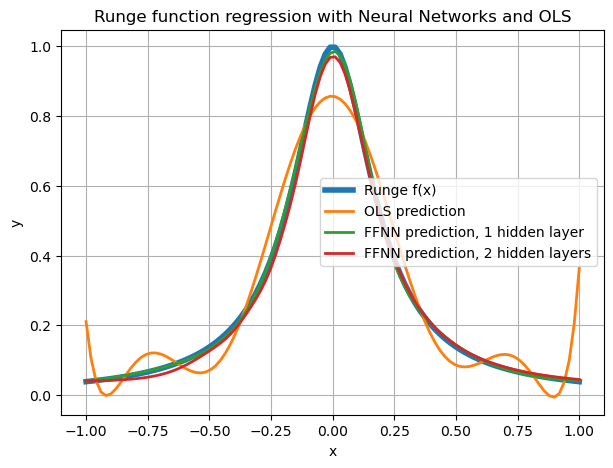

In [51]:
plt.figure(figsize=(7, 5))
# Runge function:
plt.plot(x, y, label="Runge f(x)", linewidth=4)
# OLS
plt.plot(x, y_pred_full_OLS, label="OLS prediction", linewidth=2)
# NN, 1 hidden layer:
plt.plot(x, y_pred_nn1, label="FFNN prediction, 1 hidden layer", linewidth=2)
# NN, 2 hidden layers:
plt.plot(x, y_pred_nn2, label="FFNN prediction, 2 hidden layers", linewidth=2)
# Training points?
# plt.scatter(x_train, y_train, color="black", s=15, alpha=0.6, label="Training points")
plt.title("Runge function regression with Neural Networks and OLS")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Analyzing gradient descent methods

## Adam

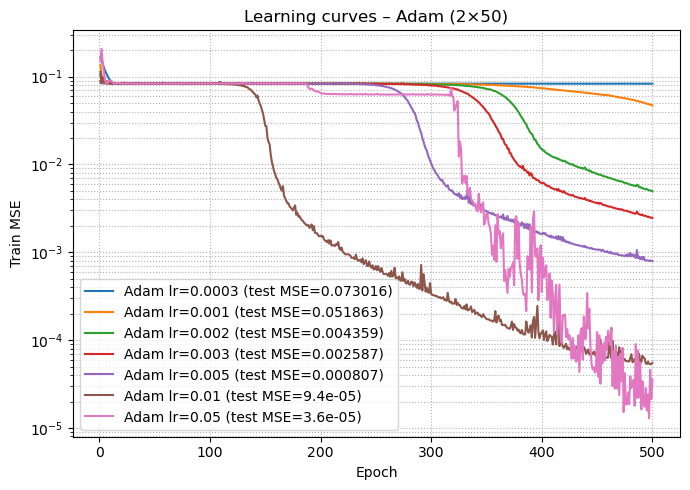

In [52]:
# Defining learning rates
learning_rates = [3e-4, 1e-3, 2e-3, 3e-3, 5e-3, 1e-2, 5e-2]
# Empty list for histories (training MSE)
histories = []
# Empty list for final test MSE
labels = []

# Generate data
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network
x_full_s = scaler_x.transform(x)

# Parameters for NeuralNetwork
layer_output_sizes = [50, 50, 1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv
# Parameters for training:
epochs = 500
batch_size = 32

# Training (using ADAM optimizer)
for lr in learning_rates:
    # Define a neural network
    nn = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)
    
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s, 
                 y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 optimizer=optimizer,
                 log_every=None)
    histories.append(history["train_loss"])
    # Compute final test MSE:
    y_pred_test = nn.predict(x_test_s)
    test_mse = mse(y_pred_test, y_test)
    labels.append(f"Adam lr={lr} (test MSE={np.round(test_mse, 6)})")

### Plotting this
plt.figure(figsize=(7,5))
for losses, lab in zip(histories, labels):
    plt.plot(range(1, len(losses)+1), losses, label=lab)
plt.yscale("log")  # ofte mer lesbart
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.title("Learning curves – Adam (2×50)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


## RMSprop

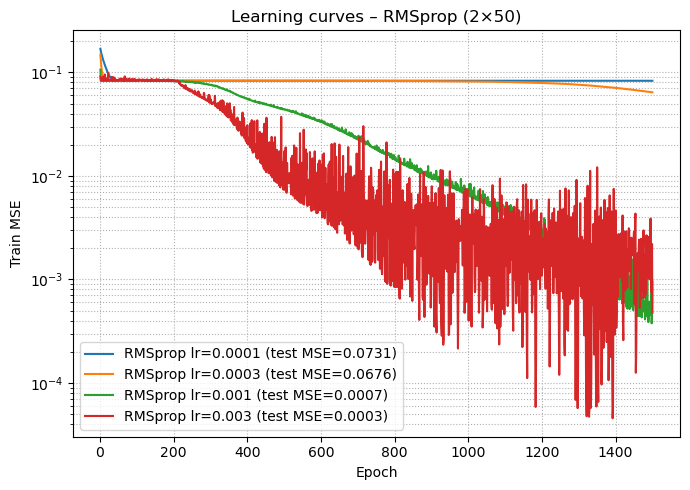

In [53]:
# Defining learning rates
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3]
# Empty list for histories (training MSE)
histories = []
# Empty list for final test MSE
labels = []

# Generate data
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network
x_full_s = scaler_x.transform(x)

# Parameters for NeuralNetwork
layer_output_sizes = [50, 50, 1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv
# Parameters for training:
epochs = 1500
batch_size = 32

# Training (using RMSprop optimizer)
for lr in learning_rates:
    # Define a neural network
    nn = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)
    
    optimizer = RMSprop(lr=lr)
    history = nn.fit(x_train_s, 
                 y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 optimizer=optimizer,
                 log_every=None)
    histories.append(history["train_loss"])
    # Compute final test MSE:
    y_pred_test = nn.predict(x_test_s)
    test_mse = mse(y_pred_test, y_test)
    labels.append(f"RMSprop lr={lr} (test MSE={np.round(test_mse, 4)})")

### Plotting this
plt.figure(figsize=(7,5))
for losses, lab in zip(histories, labels):
    plt.plot(range(1, len(losses)+1), losses, label=lab)
plt.yscale("log")  # ofte mer lesbart
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.title("Learning curves – RMSprop (2×50)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


## Plain gradient descent

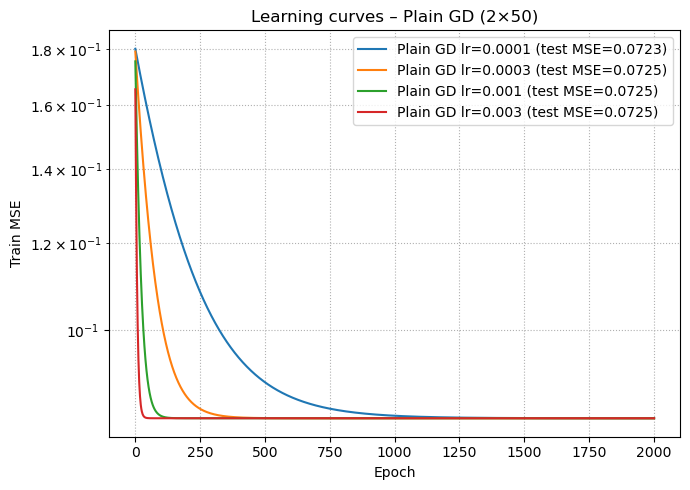

In [54]:
# Defining learning rates
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3]
# Empty list for histories (training MSE)
histories = []
# Empty list for final test MSE
labels = []

# Generate data
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

## Scaling data
scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train) #Used by neural network
x_test_s = scaler_x.transform(x_test) #Used by neural network
x_full_s = scaler_x.transform(x)

# Parameters for NeuralNetwork
layer_output_sizes = [50, 50, 1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv
# Parameters for training:
epochs = 2000
batch_size = len(x_train)

# Training (using plain GD optimizer)
for lr in learning_rates:
    # Define a neural network
    nn = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)
    
    optimizer = SGD(lr=lr)
    history = nn.fit(x_train_s, 
                 y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 optimizer=optimizer,
                 shuffle=False,
                 log_every=None)
    histories.append(history["train_loss"])
    # Compute final test MSE:
    y_pred_test = nn.predict(x_test_s)
    test_mse = mse(y_pred_test, y_test)
    labels.append(f"Plain GD lr={lr} (test MSE={np.round(test_mse, 4)})")

### Plotting this
plt.figure(figsize=(7,5))
for losses, lab in zip(histories, labels):
    plt.plot(range(1, len(losses)+1), losses, label=lab)
plt.yscale("log")  # ofte mer lesbart
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.title("Learning curves – Plain GD (2×50)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()
